<a href="https://colab.research.google.com/github/NPMachineLearning/GradCAM/blob/main/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Calss Activation Maps

https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

In [76]:
from tensorflow_datasets.core.utils.type_utils import Tensor
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
  def __init__(self, model, class_index=0, regression=False, layer_name=None):
    """
    Create a Gradient Class Activation Maps

    [Implementation](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/)
    
    Args:
      - `model`: a tensorflow pre-trained model(convolutional neural network)
      - `class_index`: index correpond to pre-trained model predicted class
      - `regression`: a boolean value True indicate pre-trained model is regression
          and `class_index` will be ignored, otherwise False classification
      - `layer_name`: name of layer in the pre-trained model, None to find target layer name
        automatically
    """
    self.model = model
    self.regression = regression
    self.class_index = class_index
    self.layer_name = layer_name

    # find the layer name if needed
    if self.layer_name is None:
      self.layer_name = self.find_target_layer()
  
  def find_target_layer(self):
    """
    find the bottom layer(conv or pool) of the model

    Returns:
     a string of layer name
    """

    # find conv or pool layer with 4d output from bottom up
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name

    # we can't find one
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, scale_heatmap=None, eps=1e-8):
    """
    Compute a heatmap from image
    
    Args:
      - `image`: an image will be used to compute heatmap
      - `scale_heatmap`: if not None then provide a tuple with 
          image size to scale heatmap to size provided, otherwise heatmap will be scaled to the size of provided image
      - `eps`: in case of divide 0

    Returns:
      a computed heatmap base on given image 
    """ 
    ### create gradient model with pre-trained model's input
    ### and outputs with layer's output and pre-trained model's output(softmax acitvation)
    grad_model = Model(inputs=[self.model.inputs],
                       outputs=[self.model.get_layer(self.layer_name).output,
                                self.model.output])
    
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (conv_outputs, predictions) = grad_model(inputs)
      if not self.regression:
        loss = predictions[:, self.class_index]
      else:
        loss = predictions[:, 0]

    
    # compute gradient
    grads = tape.gradient(loss, conv_outputs)

    ### compute guided gradient
    # create binary mask
    conv_outputs_casted = tf.cast(conv_outputs > 0, tf.float32) # output either 0 or 1 in matrix index
    grads_casted = tf.cast(grads > 0, tf.float32) # output either 0 or 1 in matrix index
    # apply binary mask on gradients
    guided_grads = conv_outputs_casted * grads_casted * grads

    # remove batch
    conv_outputs = conv_outputs[0] # shape (width, height, filter)
    guided_grads = guided_grads[0] # shape (width, height, filter)

    # compute average weights from guided gradients
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    weighted_conv_outputs = tf.multiply(weights, conv_outputs)

    #compute the ponderation of the filters with respect to the weights
    cam = tf.reduce_sum(weighted_conv_outputs, axis=-1) # shape (width, height)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (image.shape[1], image.shape[2]) if scale_heatmap is None else scale_heatmap
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255.).astype(np.uint8)
    
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    """
    Overlay a heatmap on an image
    
    Args:
      - `heatmap`: computed heatmap with `compute_heatmap`
      - `image`: image that will be applied with heatmap
      - `alpha`: alpha of image
      - `colormap`: cv2's colormap (https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html)

    Returns:
      a tuple (heatmap, output) where output is image with heatmap overlay 
    """
    # get numpy array from tensor if image is Tensor
    image = image.numpy() if isinstance(image, (tf.Tensor)) else image
    
    # apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    return (heatmap, output)
  
  @staticmethod
  def display_heatmap(model, image, scale_heatmap=None, only_overlay=True, outs=None, **kwargs):
    """
    Convenient function to display image with heatmap

    Args:
      - `model`: a tensorflow pre-trained model(convolutional neural network)
      - `image`: image that will be applied with heatmap
      - `scale_heatmap`: if not None then provide a tuple with 
          image size to scale heatmap to size provided, otherwise heatmap will be scaled to the size of provided image
      - `only_overlay`: a boolean indicate whether to only display output image which is combination of image and heatmap, 
          otherwise disaply heatmap and combination of image and heatmap 
      - `outs`: given an empty list then the list will be fill with heatmap and image with heatmap overlay as numpy array
          e.g [heatmap, image with heatmap overlay] **Note** list will be clear if it was not empty

      - `**kwargs`:
          @ `regression`: a boolean value True indicate pre-trained model is regression, otherwise
            False classification
          @ `layer_name`: name of layer in the pre-trained model, None to find target layer name
            automatically
    """
    # set size for image resizing
    to_size = [model.input.shape[1], model.input.shape[2]]

    # image resize, expand dim, cast for model prediction
    image_resized = tf.image.resize(image, to_size)
    image_resized = tf.expand_dims(image_resized, axis=0)
    image_resized = tf.cast(image_resized, tf.uint8)

    # model prediction default assume model is classification
    preds = model.predict(image_resized)
    i = tf.argmax(preds[0])

    # create class activation maps
    cam = GradCAM(model, class_index=i, **kwargs)

    # create heatmap
    heatmap = cam.compute_heatmap(image_resized, scale_heatmap)

    # create output image with heatmap
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

    if not only_overlay:
      plt.figure()
      plt.imshow(heatmap)

    plt.figure()
    plt.imshow(output)
    plt.xlabel(f"prediction: {i}")

    if outs is not None:
      if len(outs) > 0:
        outs.clear()
      outs.append(heatmap)
      outs.append(output)

## test

original image: (500, 375, 3)
predict label: 257


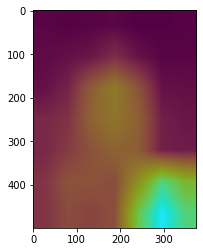

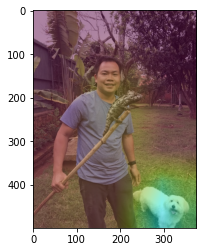

In [77]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB1

ds = tfds.load("imagenet_a", shuffle_files=True)

for data in ds["test"].take(1):
  img_origin = data["image"]
  print(f"original image: {img_origin.shape}")

  img = tf.image.resize(img_origin, [224,224])
  img = tf.expand_dims(img, axis=0)
  img = tf.cast(img, tf.uint8)

  model = ResNet50()
  preds = model.predict(img)
  i = tf.argmax(preds[0])
  print(f"predict label: {i.numpy()}")

  cam = GradCAM(model, class_index=i)

  # imagenet's image is (h, w, 3) so need to swap width and height
  heatmap = cam.compute_heatmap(img, scale_heatmap=(img_origin.shape[1], img_origin.shape[0]))
  (heatmap, output) = cam.overlay_heatmap(heatmap, img_origin, alpha=0.5, )

  plt.figure()
  plt.imshow(heatmap)
  plt.figure()
  plt.imshow(output)

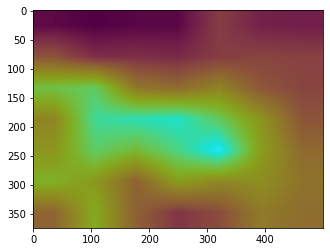

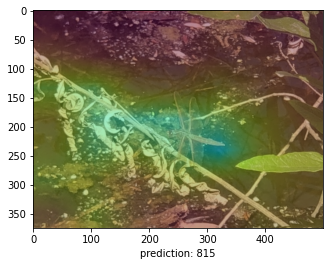

In [78]:
ds = tfds.load("imagenet_a", shuffle_files=True)

for data in ds["test"].take(1):
  img = data["image"]
  model = ResNet50()
  GradCAM.display_heatmap(model, img, 
                          scale_heatmap=(img.shape[1], img.shape[0]),
                          only_overlay=False)